In [13]:
import scanpy as sc
from utils.evaluate import evaluate_clustering

In [2]:
adata = sc.read("../data/Tosches_turtle_processed.h5ad")

c:\Users\17619\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(
C:\Users\17619\AppData\Local\Temp\ipykernel_6192\4294939803.py:27: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


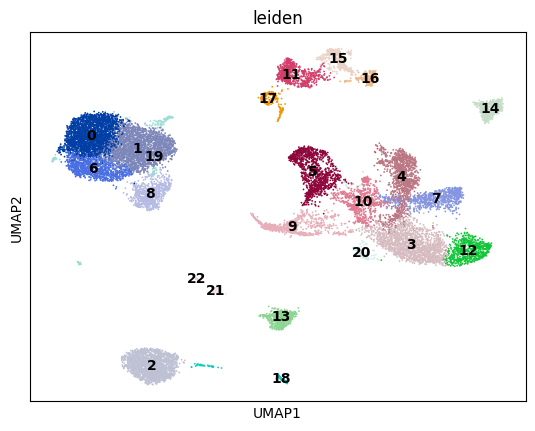

In [ ]:
# -----------------------------
# 1) PCA
# -----------------------------
# 若 adata.X 已经是 log1p 后的表达矩阵（常见做法），可以直接 PCA
# 这里 n_comps 通常设 50 左右
sc.tl.pca(adata, n_comps=50, use_highly_variable=False, svd_solver="arpack")

# 可选：看看 PCA 方差解释度
# sc.pl.pca_variance_ratio(adata, log=True)

# -----------------------------
# 2) KNN 图（neighbors）
# -----------------------------
# n_neighbors 常用 10~30；数据 18k 细胞，建议先用 15 或 20 起步
# n_pcs 使用多少个主成分构建图：常用 30~50
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    n_pcs=30,
    metric="cosine"   # 常用 'cosine' 或 'euclidean'；cosine 在 scRNA 上很常见
)

# -----------------------------
# 3) Leiden 聚类
# -----------------------------
# resolution 越大，簇越多；建议从 0.5~1.5 扫一下
sc.tl.leiden(
    adata,
    resolution=1.0,
    key_added="leiden"  # 聚类结果存到 adata.obs['leiden']
)

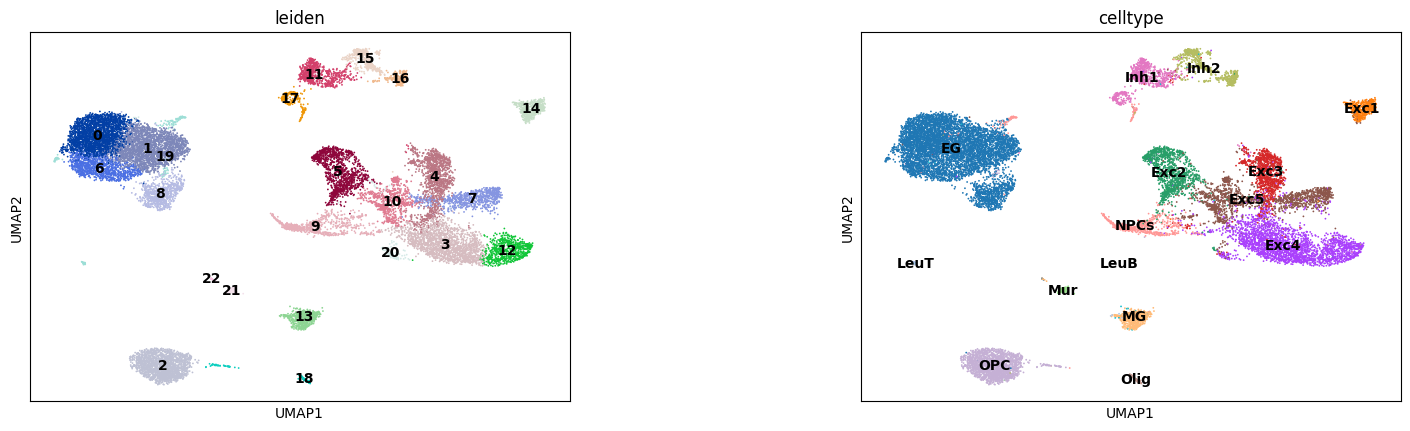

In [9]:
# -----------------------------
# 4) (推荐) UMAP 可视化
# -----------------------------
sc.tl.umap(adata, min_dist=0.3, spread=1.0)

# 同时绘制：Leiden 聚类结果 + ground-truth celltype
sc.pl.umap(
    adata,
    color=["leiden", "celltype"],
    legend_loc="on data",      # 如果 celltype 太多，建议改成 'right margin'
    wspace=0.4
)

In [11]:
cluster_labels = adata.obs['leiden'].to_list()
true_labels = adata.obs['celltype'].to_list()

print(len(cluster_labels), len(true_labels))

18301 18301


In [14]:
eval_result = evaluate_clustering(cluster_labels, true_labels)
print(eval_result)

{'NMI': 0.7742213000141379, 'ARI': 0.5023914359592311, 'ACC': 0.6267417081033824}
